In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.sparse import hstack
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
df = pd.read_csv("../data/goodreads_books.csv")
df.head()

,title,author,rating_info
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"4.35 avg rating — 9,682,830 ratings"
1,Pride and Prejudice,Jane Austen,"4.29 avg rating — 4,682,657 ratings"
2,To Kill a Mockingbird,Harper Lee,"4.26 avg rating — 6,742,178 ratings"
3,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,"4.50 avg rating — 3,720,909 ratings"
4,The Book Thief,Markus Zusak,"4.39 avg rating — 2,823,344 ratings"


In [3]:
df["avg_rating"] = df["rating_info"].str.extract(r"([0-9]\.\d+)").astype(float)
df["avg_rating"]

0        4.35
1        4.29
2        4.26
3        4.50
4        4.39
         ... 
66795    3.60
66796    3.43
66797    3.98
66798    3.80
66799    3.83
Name: avg_rating, Length: 66800, dtype: float64

In [4]:
df["num_rating"] = (df["rating_info"].str.extract(r"— ([\d,]+) ratings")[0]
                                           .str.replace(",", "", regex=True).astype(int))

df["num_rating"]

0        9682830
1        4682657
2        6742178
3        3720909
4        2823344
          ...   
66795       9557
66796      92459
66797      22679
66798      17350
66799      22612
Name: num_rating, Length: 66800, dtype: int64

In [5]:
df = df.drop(columns=["rating_info"])
df.head()

,title,author,avg_rating,num_rating
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.35,9682830
1,Pride and Prejudice,Jane Austen,4.29,4682657
2,To Kill a Mockingbird,Harper Lee,4.26,6742178
3,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,3720909
4,The Book Thief,Markus Zusak,4.39,2823344


In [6]:
df.to_csv("../data/goodreads_books_changed.csv", index=False)

In [2]:
df = pd.read_csv("../data/goodreads_books_changed.csv")
df.head()

,title,author,avg_rating,num_rating
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.35,9682830
1,Pride and Prejudice,Jane Austen,4.29,4682657
2,To Kill a Mockingbird,Harper Lee,4.26,6742178
3,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,3720909
4,The Book Thief,Markus Zusak,4.39,2823344


### EDA


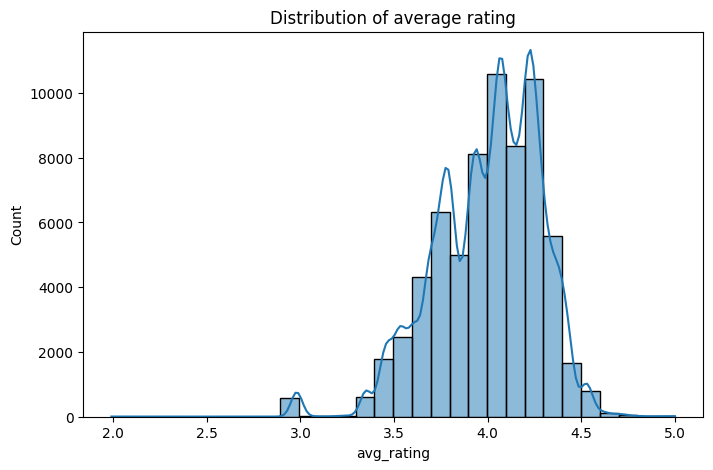

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df["avg_rating"], bins=30, kde=True)
plt.title("Distribution of average rating")
plt.show()

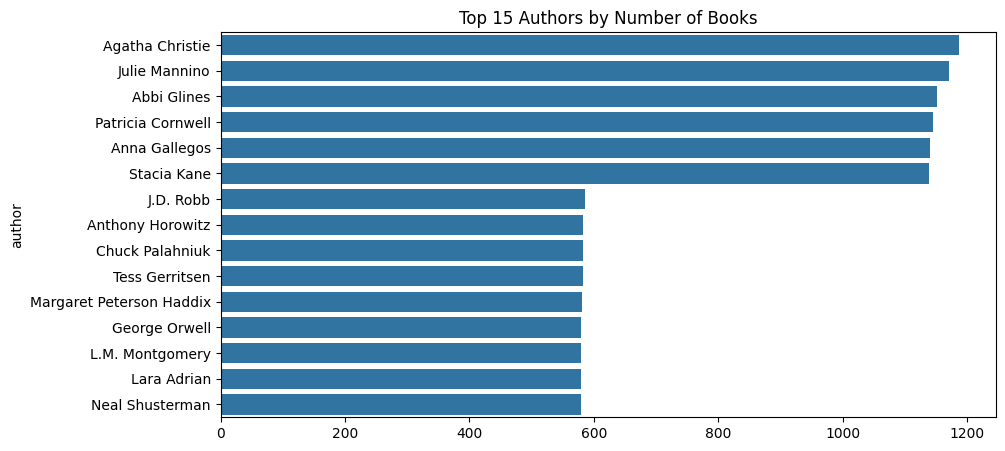

In [5]:
top_authors = df["author"].value_counts().head(15)
plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title("Top 15 Authors by Number of Books")
plt.show()

In [6]:
df["text"] = df["title"] + " " + df["author"]

tfidf = TfidfVectorizer(stop_words="english", max_features=10000)
X_text = tfidf.fit_transform(df["text"])

In [7]:
# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[['avg_rating', 'num_rating']])

# Combine features
X = hstack([X_text, X_num])

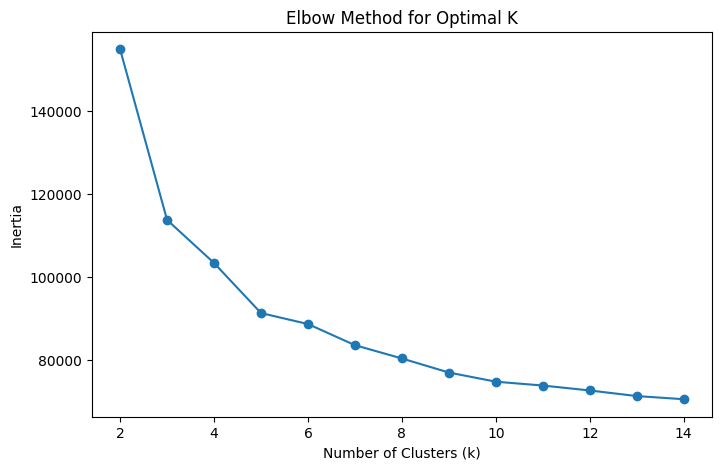

In [8]:
# Determine optimal k using Elbow Method
inertia = []
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [9]:
# Fit KMeans with chosen k
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [10]:
# Top terms for text features only
order_centroids = kmeans.cluster_centers_[:, :X_text.shape[1]].argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(optimal_k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"\nCluster {i} top terms: {', '.join(top_terms)}")



Cluster 0 top terms: death, bidadari, 11, glines, abbi, ghosts, conan, gogol, nikolai, far

Cluster 1 top terms: infected, aimee, dexter, mannino, goddess, bodeen, raft, julie, group, mccarthy

Cluster 2 top terms: potter, harry, court, rowling, 1984, roses, thorns, orwell, george, hoover

Cluster 3 top terms: dragon, altered, bone, ringworld, mannino, thomas, tryon, patricia, julie, anne

Cluster 4 top terms: maas, glass, throne, sarah, king, twisted, stephen, hoover, colleen, crows


In [11]:
cluster_labels = {
    0: "Mystery & Thriller",
    1: "Horror / Suspense",
    2: "Fiction & Fantasy",
    3: "Fantasy & Sci-Fi",
    4: "YA & Adventure"
}

df['category'] = df['cluster'].map(cluster_labels)


In [12]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save KMeans model
joblib.dump(kmeans, '../models/kmeans_model.pkl')

# Save clustered dataset
df.to_csv("../data/goodreads_books_clustered.csv", index=False)
